In [20]:
import os

# Tensorflow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers as krl
from tensorflow.keras import models as krm

#Helper libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Google file system
# from google.colab import drive
# drive.mount('/gdrive', force_remount=True)

In [2]:
BASE_DIR = './data'
ATT_FILE = f'{BASE_DIR}/FootballPlayerPreparedCleanAttributes.csv'
LABEL_FILE = f'{BASE_DIR}/FootballPlayerOneHotEncodedClasses.csv'

TRAIN_RATE = 0.8
VAL_RATE = 0.1
TEST_RATE = 0.1

attributes = pd.read_csv(ATT_FILE)
label = pd.read_csv(LABEL_FILE)

n_instances = attributes.shape[0]
n_train = int(n_instances*TRAIN_RATE)
n_val = int(n_instances*VAL_RATE)
n_test = n_instances - (n_train + n_val)

x_train = attributes.values[:n_train]
y_train = label.values[:n_train]

x_val = attributes.values[n_train:n_train+n_val]
y_val = label.values[n_train:n_train+n_val]

x_test = attributes.values[n_train+n_val:]
y_test = label.values[n_train+n_val:]

print ('x_train:', x_train.shape)
print ('y_train:', y_train.shape)

print ('x_val:', x_val.shape)
print ('y_val:', y_val.shape)

print ('x_test:', x_test.shape)
print ('y_test:', y_test.shape)

print(f'checksum: {x_train.shape[0]+x_val.shape[0]+x_test.shape[0]}={n_instances}')

x_train: (12897, 17)
y_train: (12897, 4)
x_val: (1612, 17)
y_val: (1612, 4)
x_test: (1613, 17)
y_test: (1613, 4)
checksum: 16122=16122


In [31]:
INPUTS = x_train.shape[1]
OUTPUTS = y_train.shape[1]

class Experiment:
    default_metrics = ['AUC', 'categorical_accuracy']

    default_label_name_association = {
        'auc': 'Area under ROC curve',
        'categorical_accuracy': 'Accuracy',
        'loss': 'Categorical cross-entropy (loss)'
    }

    def __init__(self, e_id, model=None, optimizer='SGD', epochs=500, metrics=None, loss='categorical_crossentropy', label_name_association=None):
        self.e_id = e_id
        self.metrics = self.default_metrics if not metrics else metrics
        self.label_name_association = self.default_label_name_association if not label_name_association else label_name_association
        self.epochs = epochs
        self.model = model
        if model:
            self.model.add(krl.Dense(units=OUTPUTS, activation='softmax'))
            self.model.compile(
                optimizer=optimizer,
                loss=loss,
                metrics=self.metrics
            )

    def run(self):
        history = self.model.fit(x_train, y_train, epochs=self.epochs, verbose=1, validation_data=(x_val, y_val))
        self.model.summary()
        self.plot_history(history)


    def plot_history(self, history, path='./models'):
        fig = plt.figure(figsize=(22, 10), constrained_layout=True)
        rows = 2
        cols = int(np.ceil(len(history.history) / (2 * rows)))
        gs = fig.add_gridspec(rows, cols)
        fig.suptitle('Resultados')

        for i, key in enumerate(self.label_name_association.keys()):
            label = self.label_name_association[key]
            r, c = i // cols, i % cols
            f_ax = fig.add_subplot(gs[r, c])
            f_ax.plot(history.history[key], label=label)
            f_ax.plot(history.history[f'val_{key}'], label=f'Validation {label.lower()}')
            f_ax.set_ylabel('')
            f_ax.set_xlabel('Epoch')
            f_ax.set_ylim(bottom=0, top=1)
            f_ax.legend(loc='upper left')
            f_ax.set_title(label)
        fig.show()
        self.print_metrics()
        plt.savefig(f'{path}/m_{self.e_id}/tfmodel', dpi=300)


    def print_metrics(self, x=x_val, y=y_val):
        loss, auc, accuracy = self.model.evaluate(x, y)
        print('Validation AUC: %.2f' % (auc * 100))
        print('Validation Accuracy: %.2f' % (accuracy * 100))

    def save(self, path='./models'):
        self.model.save(f'{path}/m_{self.e_id}/tfmodel')


    def load(self, path='./models'):
        self.model = self.model.load_model(f'{path}/m_{self.e_id}/tfmodel')

Epoch 1/5
404/404 [==============================] - 2s 3ms/step - loss: 1.3886 - auc: 0.5317 - categorical_accuracy: 0.2808 - val_loss: 1.3161 - val_auc: 0.6975 - val_categorical_accuracy: 0.4541
Epoch 2/5
404/404 [==============================] - 1s 2ms/step - loss: 1.2878 - auc: 0.7411 - categorical_accuracy: 0.5136 - val_loss: 1.2422 - val_auc: 0.7759 - val_categorical_accuracy: 0.5366
Epoch 3/5
404/404 [==============================] - 1s 2ms/step - loss: 1.2137 - auc: 0.7947 - categorical_accuracy: 0.5409 - val_loss: 1.1815 - val_auc: 0.7788 - val_categorical_accuracy: 0.5223
Epoch 4/5
404/404 [==============================] - 1s 2ms/step - loss: 1.1566 - auc: 0.7997 - categorical_accuracy: 0.5406 - val_loss: 1.1284 - val_auc: 0.8048 - val_categorical_accuracy: 0.5422
Epoch 5/5
404/404 [==============================] - 1s 2ms/step - loss: 1.0995 - auc: 0.8187 - categorical_accuracy: 0.5515 - val_loss: 1.0868 - val_auc: 0.8117 - val_categorical_accuracy: 0.5360
Model: "sequent

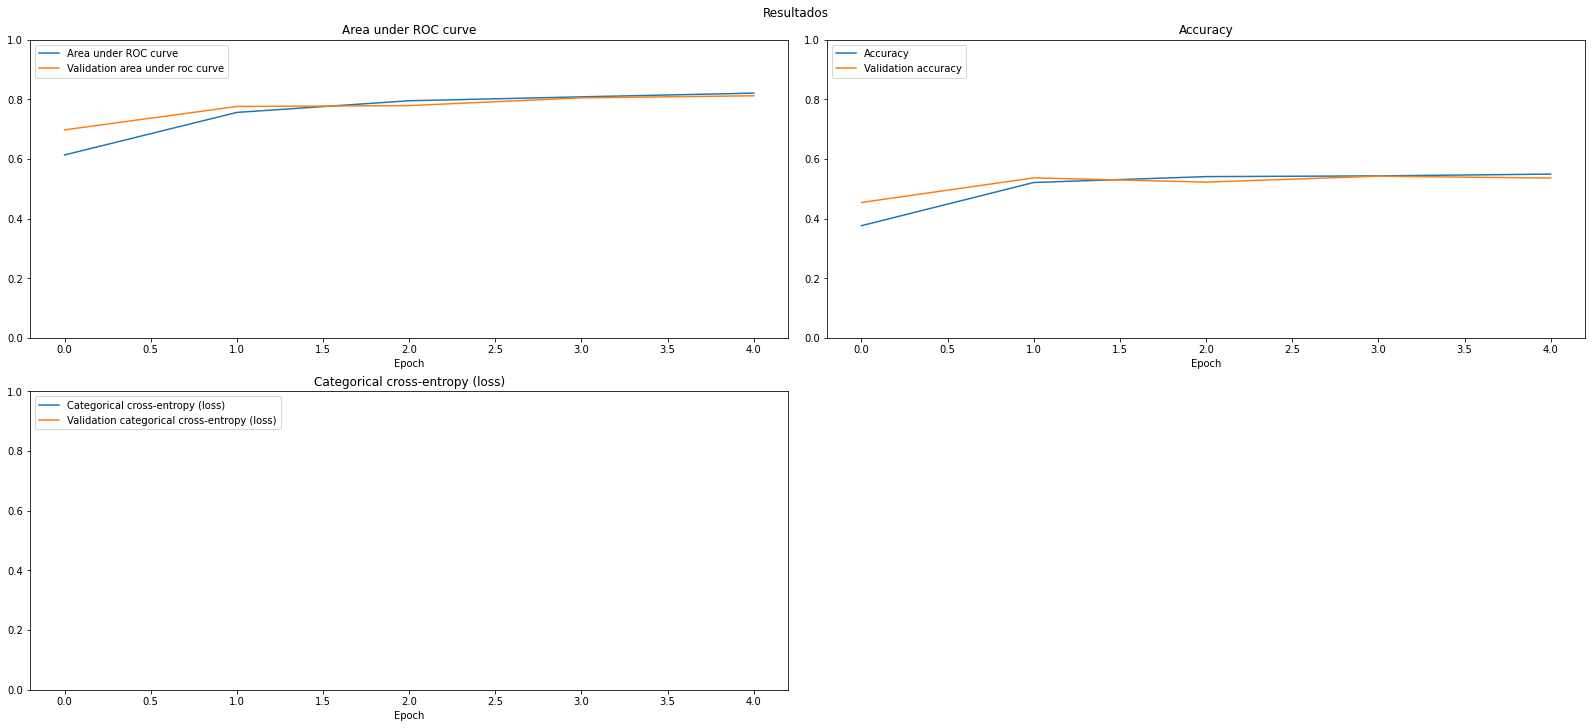

In [32]:
nn = krm.Sequential()

# Construción modelo
nn.add(krl.Dense(units=25, activation='sigmoid'))

exp = Experiment(e_id='0', model=nn, epochs=5)
exp.run()
exp.save()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3461dfc1-1017-4bae-8186-20746f5c9fc2' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>